Files already downloaded and verified
 deer   cat truck plane
torch.Size([1, 3, 32, 32])


RuntimeError: Given groups=1, weight of size [32, 1, 5, 5], expected input[1, 3, 32, 32] to have 1 channels, but got 3 channels instead

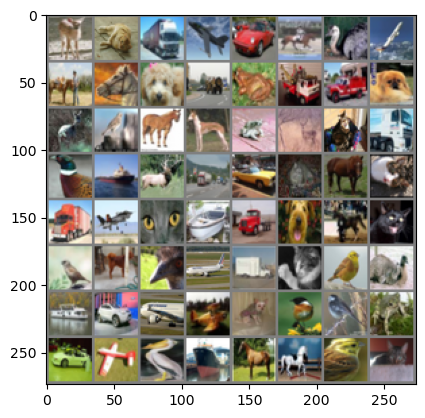

In [10]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision

# NNI package for model quantization aware training (QAT).
from nni.algorithms.compression.pytorch.quantization import QAT_Quantizer
from nni.compression.pytorch.quantization.settings import set_quant_scheme_dtype

import sys
sys.path.append('../models')

# Import NaiveModel from naive.py
from naive import NaiveModel


# Model training function
def train(model, device, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('{:2.0f}%  Loss {}'.format(100 * batch_idx / len(train_loader), loss.item()))


# Model testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('Loss: {}  Accuracy: {}%)\n'.format(
        test_loss, 100 * correct / len(test_loader.dataset)))



def main():
    torch.manual_seed(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split dataset into train/test sets.
    #trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('data', train=True, download=True, transform=trans),
        batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('data', train=False, transform=trans),
        batch_size=1000, shuffle=True)
    
    # Two things should be kept in mind when set this configure_list:
    # 1. When deploying model on backend, some layers will be fused into one layer. For example, the consecutive
    # conv + bn + relu layers will be fused into one big layer. If we want to execute the big layer in quantization
    # mode, we should tell the backend the quantization information of the input, output, and the weight tensor of
    # the big layer, which correspond to conv's input, conv's weight and relu's output.
    # 2. Same tensor should be quantized only once. For example, if a tensor is the output of layer A and the input
    # of the layer B, you should configure either {'quant_types': ['output'], 'op_names': ['a']} or
    # {'quant_types': ['input'], 'op_names': ['b']} in the configure_list.

# Quantization configuration -
# conv1, conv2 layers have INT8 weight, INT8 input activations.
# relu layers have INT8 output activations
# FC layers have INT8 weight, input, output activations

# INT8 weight, INT8 activations
    num_bits = 8

    configure_list = [{
        'quant_types': ['weight', 'input'],
        'quant_bits': {'weight': num_bits, 'input': num_bits},
        'quant_start_step': 2,
        'op_names': ['conv1', 'conv2']
    }, {
        'quant_types': ['output'],
        'quant_bits': {'output': num_bits},
        'quant_start_step': 2,
        'op_names': ['relu1', 'relu2', 'relu3']
    }, {
        'quant_types': ['output', 'weight', 'input'],
        'quant_bits': {'output': num_bits, 'weight': num_bits, 'input': num_bits},
        'quant_start_step': 2,
        'op_names': ['fc1', 'fc2'],
    }]

    # you can also set the quantization dtype and scheme layer-wise through configure_list like:
    # configure_list = [{
    #         'quant_types': ['weight', 'input'],
    #         'quant_bits': {'weight': 8, 'input': 8},
    #         'op_names': ['conv1', 'conv2'],
    #         'quant_dtype': 'int',
    #         'quant_scheme': 'per_channel_symmetric'
    #       }]
    # For now quant_dtype's options are 'int' and 'uint. And quant_scheme's options are per_tensor_affine,
    # per_tensor_symmetric, per_channel_affine and per_channel_symmetric.

    # per_tensor_symmetric quantization scheme - see [Jacob et. al]
    set_quant_scheme_dtype('weight', 'per_tensor_symmetric', 'int')
    set_quant_scheme_dtype('output', 'per_tensor_symmetric', 'int')
    set_quant_scheme_dtype('input', 'per_tensor_symmetric', 'int')

    model = NaiveModel().to(device)
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # To enable batch normalization folding in the training process, you should
    # pass dummy_input to the QAT_Quantizer.

    quantizer = QAT_Quantizer(model, configure_list, optimizer, dummy_input=dummy_input)
    quantizer.compress()

# Train and test/evaluate for 10 epoch
    model.to(device)
    for epoch in range(10):
        print('# Epoch {} #'.format(epoch))
        train(model, device, train_loader, optimizer)
        test(model, device, test_loader)

# Save quantized model parameters
    model_path = "cifar_model.pth"
    calibration_path = "cifar_calibration.pth"
    onnx_path = "cifar_model.onnx"
    input_shape = (1, 3, 32, 32)
    torch.save(model.state_dict(), model_path)

# Quantize model with QAT_Quantizer (see NNI package)
#https://nni.readthedocs.io/en/stable/compression/quantization.html
# https://github.com/microsoft/nni

    qmodel = NaiveModel().to(device)
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    optimizer = torch.optim.SGD(qmodel.parameters(), lr=0.01, momentum=0.5)
    # To enable batch normalization folding in the training process, you should
    # pass dummy_input to the QAT_Quantizer.
    quantizer = QAT_Quantizer(qmodel, configure_list, optimizer, dummy_input=dummy_input)
    quantizer.compress()
    state = torch.load(model_path, map_location='cuda')
    qmodel.load_state_dict(state, strict=True)
    test(qmodel, device, test_loader)


'''''''''''
q_model = NaiveModel().to(device)
dummy_input = torch.randn(1, 3, 32, 32).to(device)
optimizer = torch.optim.SGD(q_model.parameters(), lr=0.01, momentum=0.5)
    # To enable batch normalization folding in the training process, you should
    # pass dummy_input to the QAT_Quantizer.
quantizer = QAT_Quantizer(q_model, configure_list, optimizer, dummy_input=dummy_input)
quantizer.compress()

q_model.load_state_dict(torch.load("cifar_model.pth", map_location=device))
q_model.eval()
'''''''''''''''

if __name__ == '__main__':
    main()